In [15]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os
import re
from gensim.models import word2vec
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import tempfile
import subprocess
from typing import List, Union
import matplotlib.pyplot as plt 

RandomSeed = 42
np.random.seed(RandomSeed)


pd.set_option("display.max_colwidth", False)
pd.set_option('display.expand_frame_repr', False)
sns.set(font_scale = 1.2)

AA_array = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

kd = {"A": 1.8, "R": -4.5, "N": -3.5, "D": -3.5,
      "C": 2.5,  "Q": -3.5, "E": -3.5, "G": -0.4, "H": -3.2,
      "I": 4.5,
      "L": 3.8, "K": -3.9,
      "M": 1.9,
      "F": 2.8, "P": -1.6, "S": -0.8, "T": -0.7, "W": -0.9, "Y": -1.3,
      "V": 4.2} 


Hydrophobic_AAs = ['A', 'I', 'L', 'M', 'F', 'V']
Polar_AAs = ['S', 'Q', 'N', 'G', 'C', 'T', 'P']
Cation_AAs = ['K', 'R', 'H']
Anion_AAs = ['D', 'E']
Arom_AAs = ['W', 'Y', 'F']



def hydrophobicity(seq):
    sequence = ProteinAnalysis(seq)
    HB = 0
    for k in range(0, len(AA_array)):
        HB = HB + sequence.count_amino_acids()[AA_array[k]] * kd[AA_array[k]]        
    
    return HB


def Shannon_entropy(seq):
    sequence =  ProteinAnalysis(seq)
    entropy = 0
    for k in range(0, len(AA_array)):
        if sequence.get_amino_acids_percent()[AA_array[k]] == 0:
            entropy = entropy + 0
        else:
            entropy = entropy - math.log2(sequence.get_amino_acids_percent()[AA_array[k]]) * sequence.get_amino_acids_percent()[AA_array[k]]        
    
    return entropy




def extract_IDR(seq):
    tmp_IDR = tempfile.NamedTemporaryFile()  
    with open(tmp_IDR.name, 'w') as f_IDR:
         f_IDR.write('>1\n' + str(seq))
    tmp_IDR.seek(0)
    
    out = subprocess.Popen(['python', 'iupred2a.py', str(tmp_IDR.name), 'long'], 
           stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    stdout_IDR, stderr_IDR = out.communicate()
    stdout_IDR = stdout_IDR.split()[40:]
    
    IDR_prob = []
    for i in range(0, int(len(stdout_IDR)/3)):
        IDR_prob.append(float(str(stdout_IDR[3*i + 2], 'utf-8')))
       
    TH1 = 0.5
    TH2 = 20
    AAs   = pd.Series(list(map(lambda i:i, seq)))    
    IDR_residues = []
    current = 0
    for t in range(0, len(IDR_prob)):
        if IDR_prob[t] > TH1:
            current = current + 1
            if t == len(IDR_prob) - 1:
                if current > TH2:
                    IDR_residues.extend(range(t - current , t + 1))
        else:
            if current > TH2:
                IDR_residues.extend(range(t - current , t + 1))
                current = 0
            else:
                current = 0
    #IDR_seq = AAs[IDR_residues].str.cat()
  
    return len(IDR_residues), #IDR_seq


def get_AA_count(seq, AA):
    if type(seq) == float:
        count = 0
    else:
        sequence = ProteinAnalysis(seq)
        count = sequence.count_amino_acids()[str(AA)]
    return count


def phys_features(sequence):
   # Evaluate sequence specific parameters that the model uses:
    df = pd.DataFrame({'Sequence' : [sequence]})
    df['Sequence_length'] = df['Sequence'].str.len()
    df['Hydrophobicity'] = hydrophobicity(str(df['Sequence']))
    df['Shannon_entropy'] = Shannon_entropy(str(df['Sequence'])) 
    IDR_reg = extract_IDR(df['Sequence'].item())
    #df['IDR_sequence']  = IDR_reg[1]
    df['IDR_fraction']  = IDR_reg/ df['Sequence_length']
    

    
    return df


In [3]:
#test
myseq = 'MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY'
phys_features(myseq)

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction
0,MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYSSYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQSSSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNSSSGGGGGGGGGGNYGQDQSSMSSGGGSGGGYGNQDQSGGGGSGGYGQQDRGGRGRGGSGGGGGGGGGGYNRSSGGYEPRGRGGGRGGRGGMGGSDRGGFNKFGGPRDQGSRHDSEQDNSDNNTIFVQGLGENVTIESVADYFKQIGIIKTNKKTGQPMINLYTDRETGKLKGEATVSFDDPPSAKAAIDWFDGKEFSGNPIKVSFATRRADFNRGGGNGRGGRGRGGPMGRGGYGGGGSGGGGRGGFPSGGGGGGGQQRAGDWKCPNPTCENMNFSWRNECNQCKAPKPDGPGGGPGGSHMGGNYGDDRRGGRGGYDRGGYRGRGGDRGGFRGGRGGGDRGGFGPGKMDSRGEHRQDRRERPY,526,-698.3,3.398065,0.89924


In [4]:
df1 = pd.read_excel('uniprot-filtered-organism__Homo+sapiens+(Human)+(9606)_+AND+review--.xlsx')

In [5]:
df1.index = df1['Entry']
df1 = df1.drop(['Entry', 'Entry name', 'Protein names', 'Gene names', 'Status', 'Gene ontology (biological process)', 'Gene ontology (cellular component)', 'Gene ontology (molecular function)'], axis=1)


In [7]:
df2 = pd.read_excel('proteins.xlsx')
df2.index = df2['Uniprot_ID']
df2 = df2.drop(['Uniprot_ID'], axis=1)
df2

,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF
Uniprot_ID,,,,
O00401,0.990,1.00,0.830,0.80
O14641,0.980,1.00,0.905,0.90
O15116,0.025,0.00,0.230,0.26
O15169,0.915,0.95,0.760,0.69
O15550,0.870,0.90,0.760,0.59
...,...,...,...,...
Q9Y3R0,0.875,0.96,0.790,0.62
Q9Y4Y9,0.040,0.00,0.685,0.22
Q9Y4Z0,0.115,0.72,0.235,0.34


In [8]:
men_with_venn = df2.applymap(lambda x:x>=0.5)
men_with_venn

,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF
Uniprot_ID,,,,
O00401,True,True,True,True
O14641,True,True,True,True
O15116,False,False,False,False
O15169,True,True,True,True
O15550,True,True,True,True
...,...,...,...,...
Q9Y3R0,True,True,True,True
Q9Y4Y9,False,False,True,False
Q9Y4Z0,False,True,False,False


In [9]:
index_intersection = df2.index.intersection(df1.index.unique())
index_intersection

Index(['O00401', 'O14641', 'O15116', 'O15169', 'O15550', 'O43390', 'O43561',
       'O43663', 'O43670', 'O43781',
       ...
       'Q9ULX6', 'Q9UPQ9', 'Q9UQ35', 'Q9Y230', 'Q9Y333', 'Q9Y3R0', 'Q9Y4Y9',
       'Q9Y4Z0', 'Q9Y580', 'Q9Y6X2'],
      dtype='object', length=196)

In [10]:
df3=df1.loc[index_intersection]
df3

,Sequence,Gene ontology (GO),Gene ontology IDs
O00401,MSSVQQQPPPPRRVTNVGSLLLTPQENESLFTFLGKKCVTMSSAVVQLYAADRNCMWSKKCSGVACLVKDNPQRSYFLRIFDIKDGKLLWEQELYNNFVYNSPRGYFHTFAGDTCQVALNFANEEEAKKFRKAVTDLLGRRQRKSEKRRDPPNGPNLPMATVDIKNPEITTNRFYGPQVNNISHTKEKKKGKAKKKRLTKADIGTPSNFQHIGHVGWDPNTGFDLNNLDPELKNLFDMCGISEAQLKDRETSKVIYDFIEKTGGVEAVKNELRRQAPPPPPPSRGGPPPPPPPPHNSGPPPPPARGRGAPPPPPSRAPTAAPPPPPPSRPSVAVPPPPPNRMYPPPPPALPSSAPSGPPPPPPSVLGVGPVAPPPPPPPPPPPGPPPPPGLPSDGDHQVPTTAGNKAALLDQIREGAQLKKVEQNSRPVSCSGRDALLDQIRQGIQLKSVADGQESTPPTPAPTSGIVGALMEVMQKRSKAIHSSDEDEDEDDEEDFEDDDEWED,actin cap [GO:0030478]; actin cytoskeleton [GO:0015629]; actin filament [GO:0005884]; cytoplasmic vesicle [GO:0031410]; cytosol [GO:0005829]; endocytic vesicle membrane [GO:0030666]; extracellular exosome [GO:0070062]; lamellipodium [GO:0030027]; nucleus [GO:0005634]; plasma membrane [GO:0005886]; actin binding [GO:0003779]; GTPase regulator activity [GO:0030695]; actin filament polymerization [GO:0030041]; actin filament-based movement [GO:0030048]; actin polymerization or depolymerization [GO:0008154]; cell division [GO:0051301]; cellular protein-containing complex localization [GO:0034629]; dendritic spine morphogenesis [GO:0060997]; ephrin receptor signaling pathway [GO:0048013]; Fc-gamma receptor signaling pathway involved in phagocytosis [GO:0038096]; membrane organization [GO:0061024]; negative regulation of lymphocyte migration [GO:2000402]; negative regulation of membrane tubulation [GO:1903526]; positive regulation of Arp2/3 complex-mediated actin nucleation [GO:2000601]; positive regulation of clathrin-dependent endocytosis [GO:2000370]; positive regulation of filopodium assembly [GO:0051491]; positive regulation of transcription by RNA polymerase II [GO:0045944]; protein-containing complex assembly [GO:0065003]; regulation of nitric-oxide synthase activity [GO:0050999]; regulation of protein localization [GO:0032880]; response to bacterium [GO:0009617]; spindle localization [GO:0051653]; vesicle budding from membrane [GO:0006900]; vesicle organization [GO:0016050]; vesicle transport along actin filament [GO:0030050],GO:0003779; GO:0005634; GO:0005829; GO:0005884; GO:0005886; GO:0006900; GO:0008154; GO:0009617; GO:0015629; GO:0016050; GO:0030027; GO:0030041; GO:0030048; GO:0030050; GO:0030478; GO:0030666; GO:0030695; GO:0031410; GO:0032880; GO:0034629; GO:0038096; GO:0045944; GO:0048013; GO:0050999; GO:0051301; GO:0051491; GO:0051653; GO:0060997; GO:0061024; GO:0065003; GO:0070062; GO:1903526; GO:2000370; GO:2000402; GO:2000601
O14641,MAGSSTGGGGVGETKVIYHLDEEETPYLVKIPVPAERITLGDFKSVLQRPAGAKYFFKSMDQDFGVVKEEISDDNARLPCFNGRVVSWLVSSDNPQPEMAPPVHEPRAELAPPAPPLPPLPPERTSGIGDSRPPSFHPNVSSSHENLEPETETESVVSLRRERPRRRDSSEHGAGGHRTGGPSRLERHLAGYESSSTLMTSELESTSLGDSDEEDTMSRFSSSTEQSSASRLLKRHRRRRKQRPPRLERTSSFSSVTDSTMSLNIITVTLNMEKYNFLGISIVGQSNERGDGGIYIGSIMKGGAVAADGRIEPGDMLLQVNDMNFENMSNDDAVRVLRDIVHKPGPIVLTVAKCWDPSPQAYFTLPRNEPIQPIDPAAWVSHSAALTGTFPAYPGSSSMSTITSGSSLPDGCEGRGLSVHTDMASVTKAMAAPESGLEVRDRMWLKITIPNAFLGSDVVDWLYHHVEGFPERREARKYASGLLKAGLIRHTVNKITFSEQCYYVFGDLSGGCESYLVNLSLNDNDGSSGASDQDTLAPLPGATPWPLLPTFSYQYPAPHPYSPQPPPYHELSSYTYGGGSASSQHSEGSRSSGSTRSDGGAGRTGRPEERAPESKSGSGSESEPSSRGGSLRRGGEASGTSDGGPPPSRGSTGGAPNLRAHPGLHPYGPPPGMALPYNPMMVVMMPPPPPPVPPAVQPPGAPPVRDLGSVPPELTASRQSFHMAMGNPSEFFVDVM,"aggresome [GO:0016235]; apical part of cell [GO:0045177]; clathrin-coated endocytic vesicle [GO:0045334]; cytoplasm [GO:0005737]; cytoplasmic vesicle [GO:0031410]; cytosol [GO:0005829]; lateral plasma membrane [GO:0016328]; nuclear body [GO:0016604]; nucleoplasm [GO:0005654]; nucleus [GO:0005634]; frizzled binding [GO:0005109]; identical protein binding [GO:0042802]; protein domain specific binding [GO:0019904]; protein kinase binding [GO:0019901]; protein self-association [GO:0043621]; protein-macromolecule adaptor activity [GO:0030674]; Rac GTPase binding [GO:0048365]; beta-catenin destruction complex disassembly [GO:1904886]; canonical Wnt signaling pathway [GO:0060070]; canonical Wnt signaling pathway involve

In [11]:
sequences = df3['Sequence'].tolist()


In [12]:
temp_c = [phys_features(t) for t in sequences]
temp_c_df = pd.concat(temp_c)
temp_c_df.index = df2.index
temp_c_df

,Sequence,Sequence_length,Hydrophobicity,Shannon_entropy,IDR_fraction
Uniprot_ID,,,,,
O00401,MSSVQQQPPPPRRVTNVGSLLLTPQENESLFTFLGKKCVTMSSAVVQLYAADRNCMWSKKCSGVACLVKDNPQRSYFLRIFDIKDGKLLWEQELYNNFVYNSPRGYFHTFAGDTCQVALNFANEEEAKKFRKAVTDLLGRRQRKSEKRRDPPNGPNLPMATVDIKNPEITTNRFYGPQVNNISHTKEKKKGKAKKKRLTKADIGTPSNFQHIGHVGWDPNTGFDLNNLDPELKNLFDMCGISEAQLKDRETSKVIYDFIEKTGGVEAVKNELRRQAPPPPPPSRGGPPPPPPPPHNSGPPPPPARGRGAPPPPPSRAPTAAPPPPPPSRPSVAVPPPPPNRMYPPPPPALPSSAPSGPPPPPPSVLGVGPVAPPPPPPPPPPPGPPPPPGLPSDGDHQVPTTAGNKAALLDQIREGAQLKKVEQNSRPVSCSGRDALLDQIRQGIQLKSVADGQESTPPTPAPTSGIVGALMEVMQKRSKAIHSSDEDEDEDDEEDFEDDDEWED,505,-426.2,3.846972,0.704950
O14641,MAGSSTGGGGVGETKVIYHLDEEETPYLVKIPVPAERITLGDFKSVLQRPAGAKYFFKSMDQDFGVVKEEISDDNARLPCFNGRVVSWLVSSDNPQPEMAPPVHEPRAELAPPAPPLPPLPPERTSGIGDSRPPSFHPNVSSSHENLEPETETESVVSLRRERPRRRDSSEHGAGGHRTGGPSRLERHLAGYESSSTLMTSELESTSLGDSDEEDTMSRFSSSTEQSSASRLLKRHRRRRKQRPPRLERTSSFSSVTDSTMSLNIITVTLNMEKYNFLGISIVGQSNERGDGGIYIGSIMKGGAVAADGRIEPGDMLLQVNDMNFENMSNDDAVRVLRDIVHKPGPIVLTVAKCWDPSPQAYFTLPRNEPIQPIDPAAWVSHSAALTGTFPAYPGSSSMSTITSGSSLPDGCEGRGLSVHTDMASVTKAMAAPESGLEVRDRMWLKITIPNAFLGSDVVDWLYHHVEGFPERREARKYASGLLKAGLIRHTVNKITFSEQCYYVFGDLSGGCESYLVNLSLNDNDGSSGASDQDTLAPLPGATPWPLLPTFSYQYPAPHPYSPQPPPYHELSSYTYGGGSASSQHSEGSRSSGSTRSDGGAGRTGRPEERAPESKSGSGSESEPSSRGGSLRRGGEASGTSDGGPPPSRGSTGGAPNLRAHPGLHPYGPPPGMALPYNPMMVVMMPPPPPPVPPAVQPPGAPPVRDLGSVPPELTASRQSFHMAMGNPSEFFVDVM,736,-421.3,3.911254,0.464674
O15116,MNYMPGTASLIEDIDKKHLVLLRDGRTLIGFLRSIDQFANLVLHQTVERIHVGKKYGDIPRGIFVVRGENVVLLGEIDLEKESDTPLQQVSIEEILEEQRVEQQTKLEAEKLKVQALKDRGLSIPRADTLDEY,133,-48.8,3.427337,0.000000
O15169,MNIQEQGFPLDLGASFTEDAPRPPVPGEEGELVSTDPRPASYSFCSGKGVGIKGETSTATPRRSDLDLGYEPEGSASPTPPYLKWAESLHSLLDDQDGISLFRTFLKQEGCADLLDFWFACTGFRKLEPCDSNEEKRLKLARAIYRKYILDNNGIVSRQTKPATKSFIKGCIMKQLIDPAMFDQAQTEIQATMEENTYPSFLKSDIYLEYTRTGSESPKVCSDQSSGSGTGKGISGYLPTLNEDEEWKCDQDMDEDDGRDAAPPGRLPQKLLLETAAPRVSSSRRYSEGREFRYGSWREPVNPYYVNAGYALAPATSANDSEQQSLSSDADTLSLTDSSVDGIPPYRIRKQHRREMQESVQVNGRVPLPHIPRTYRVPKEVRVEPQKFAEELIHRLEAVQRTREAEEKLEERLKRVRMEEEGEDGDPSSGPPGPCHKLPPAPAWHHFPPRCVDMGCAGLRDAHEENPESILDEHVQRVLRTPGRQSPGPGHRSPDSGHVAKMPVALGGAASGHGKHVPKSGAKLDAAGLHHHRHVHHHVHHSTARPKEQVEAEATRRAQSSFAWGLEPHSHGARSRGYSESVGAAPNASDGLAHSGKVGVACKRNAKKAESGKSASTEVPGASEDAEKNQKIMQWIIEGEKEISRHRRTGHGSSGTRKPQPHENSRPLSLEHPWAGPQLRTSVQPSHLFIQDPTMPPHPAPNPLTQLEEARRRLEEEEKRASRAPSKQRYVQEVMRRGRACVRPACAPVLHVVPAVSDMELSETETRSQRKVGGGSAQPCDSIVVAYYFCGEPIPYRTLVRGRAVTLGQFKELLTKKGSYRYYFKKVSDEFDCGVVFEEVREDEAVLPVFEEKIIGKVEKVD,862,-688.6,4.007694,0.548724
O15550,MKSCGVSLATAAAAAAAFGDEEKKMAAGKASGESEEASPSLTAEEREALGGLDSRLFGFVRFHEDGARTKALLGKAVRCYESLILKAEGKVESDFFCQLGHFNLLLEDYPKALSAYQRYYSLQSDYWKNAAFLYGLGLVYFHYNAFQWAIKAFQEVLYVDPSFCRAKEIHLRLGLMFKVNTDYESSLKHFQLALVDCNPCTLSNAEIQFHIAHLYETQRKYHSAKEAYEQLLQTENLSAQVKATVLQQLGWMHHTVDLLGDKATKESYAIQYLQKSLEADPNSGQSWYFLGRCYSSIGKVQDAFISYRQSIDKSEASADTWCSIGVLYQQQNQPMDALQAYICAVQLDHGHAAAWMDLGTLYESCNQPQDAIKCYLNATRSKSCSNTSALAARIKYLQAQLCNLPQGSLQNKTKLLPSIEEAWSLPIPAELTSRQGAMNTAQQNTSDNWSGGHAVSHPPVQQQAHSWCLTPQKLQHLEQLRANRNNLNPAQKLMLEQLESQFVLMQQHQMRPTGVAQVRSTGIPNGPTADSSLPTNSVSGQQPQLALTRVPSVSQPGVRPACPGQPLANGPFSAGHVPCSTSRTLGSTDTILIGNNHITGSGSNGNVPYLQRNALTLPHNRTNLTSSAEEPWKNQLSNSTQGLHKGQSSHSAGPNGERPLSSTGPSQHLQAAGSGIQNQNGHPTLPSNSVTQGAALNHLSSHTATSGGQQGITLTKESKPSGNILTVPETSRHTGETPNSTASVEGLPNHVHQMTADAVCSPSHGDSKSPGLLSSDNPQLSALLMGKANNNVGTGTCDKVNNIHPAVHTKTDNSVASSPSSAISTATPSPKSTEQTTTNSVTSLNSPHSGLHTINGEGMEESQSPMKTDLLLVNHKPSPQIIPSMSVSIYPSSAEVLKACRNLGKNGLSNSSILLDKCPPPRPPSSPYPPLPKDKLNPPTPSIYLENKRDAFFPPLHQFCTNPNNPVTVIRGLAGALKLDLGLFSTKTLVEANNEHMVEVRTQLLQPADENWDPTGTKKIWHCESNRSHTTIAKYAQYQASSFQESLREENEKRSHHKDHSDSESTSSDNSGRRRKGPFKTIKFGTNIDLSDDKKWKLQLHELTKLPAFVRVVSAGNLLSHVGHTILGMNTVQLYMKVPGSRTPGHQENNNFCSVNINIGPGDCEWFVVPEGYWGVLNDFCEKNNLNFLMGSWWPNLEDLYEANVPVYRFIQRPGDLVWINAGTVHWVQAIGWCNNIAWNVGPLTACQYKLAVERYEWNKLQSVKSIVPMVHLSWNMARNIKVSDPKLFEMIKYCLLRTLKQCQTLREALIAAGKEIIWHGRTKEEPAHYCSICEVEVFDLLFVTNESNSRKTYIVHCQDCARKTSGNLENFVVLEQYKMEDLMQVYDQFTLAPPLPSASS,1401,-647.5,4.096787,0.336188
...,...,...,...,...,...
Q9Y3R0,MIAVSFKCRCQILRRLTKDESPYTKSASQTKPPDGALAVRRQSIPEEFKGSTVVELMKKEG

In [13]:
proteins = temp_c_df.join(df2, how = 'outer')
proteins = proteins.drop(['Hydrophobicity', 'Shannon_entropy', 'Sequence_length'], axis=1)
proteins

,Sequence,IDR_fraction,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF
Uniprot_ID,,,,,,
O00401,MSSVQQQPPPPRRVTNVGSLLLTPQENESLFTFLGKKCVTMSSAVVQLYAADRNCMWSKKCSGVACLVKDNPQRSYFLRIFDIKDGKLLWEQELYNNFVYNSPRGYFHTFAGDTCQVALNFANEEEAKKFRKAVTDLLGRRQRKSEKRRDPPNGPNLPMATVDIKNPEITTNRFYGPQVNNISHTKEKKKGKAKKKRLTKADIGTPSNFQHIGHVGWDPNTGFDLNNLDPELKNLFDMCGISEAQLKDRETSKVIYDFIEKTGGVEAVKNELRRQAPPPPPPSRGGPPPPPPPPHNSGPPPPPARGRGAPPPPPSRAPTAAPPPPPPSRPSVAVPPPPPNRMYPPPPPALPSSAPSGPPPPPPSVLGVGPVAPPPPPPPPPPPGPPPPPGLPSDGDHQVPTTAGNKAALLDQIREGAQLKKVEQNSRPVSCSGRDALLDQIRQGIQLKSVADGQESTPPTPAPTSGIVGALMEVMQKRSKAIHSSDEDEDEDDEEDFEDDDEWED,0.704950,0.990,1.00,0.830,0.80
O14641,MAGSSTGGGGVGETKVIYHLDEEETPYLVKIPVPAERITLGDFKSVLQRPAGAKYFFKSMDQDFGVVKEEISDDNARLPCFNGRVVSWLVSSDNPQPEMAPPVHEPRAELAPPAPPLPPLPPERTSGIGDSRPPSFHPNVSSSHENLEPETETESVVSLRRERPRRRDSSEHGAGGHRTGGPSRLERHLAGYESSSTLMTSELESTSLGDSDEEDTMSRFSSSTEQSSASRLLKRHRRRRKQRPPRLERTSSFSSVTDSTMSLNIITVTLNMEKYNFLGISIVGQSNERGDGGIYIGSIMKGGAVAADGRIEPGDMLLQVNDMNFENMSNDDAVRVLRDIVHKPGPIVLTVAKCWDPSPQAYFTLPRNEPIQPIDPAAWVSHSAALTGTFPAYPGSSSMSTITSGSSLPDGCEGRGLSVHTDMASVTKAMAAPESGLEVRDRMWLKITIPNAFLGSDVVDWLYHHVEGFPERREARKYASGLLKAGLIRHTVNKITFSEQCYYVFGDLSGGCESYLVNLSLNDNDGSSGASDQDTLAPLPGATPWPLLPTFSYQYPAPHPYSPQPPPYHELSSYTYGGGSASSQHSEGSRSSGSTRSDGGAGRTGRPEERAPESKSGSGSESEPSSRGGSLRRGGEASGTSDGGPPPSRGSTGGAPNLRAHPGLHPYGPPPGMALPYNPMMVVMMPPPPPPVPPAVQPPGAPPVRDLGSVPPELTASRQSFHMAMGNPSEFFVDVM,0.464674,0.980,1.00,0.905,0.90
O15116,MNYMPGTASLIEDIDKKHLVLLRDGRTLIGFLRSIDQFANLVLHQTVERIHVGKKYGDIPRGIFVVRGENVVLLGEIDLEKESDTPLQQVSIEEILEEQRVEQQTKLEAEKLKVQALKDRGLSIPRADTLDEY,0.000000,0.025,0.00,0.230,0.26
O15169,MNIQEQGFPLDLGASFTEDAPRPPVPGEEGELVSTDPRPASYSFCSGKGVGIKGETSTATPRRSDLDLGYEPEGSASPTPPYLKWAESLHSLLDDQDGISLFRTFLKQEGCADLLDFWFACTGFRKLEPCDSNEEKRLKLARAIYRKYILDNNGIVSRQTKPATKSFIKGCIMKQLIDPAMFDQAQTEIQATMEENTYPSFLKSDIYLEYTRTGSESPKVCSDQSSGSGTGKGISGYLPTLNEDEEWKCDQDMDEDDGRDAAPPGRLPQKLLLETAAPRVSSSRRYSEGREFRYGSWREPVNPYYVNAGYALAPATSANDSEQQSLSSDADTLSLTDSSVDGIPPYRIRKQHRREMQESVQVNGRVPLPHIPRTYRVPKEVRVEPQKFAEELIHRLEAVQRTREAEEKLEERLKRVRMEEEGEDGDPSSGPPGPCHKLPPAPAWHHFPPRCVDMGCAGLRDAHEENPESILDEHVQRVLRTPGRQSPGPGHRSPDSGHVAKMPVALGGAASGHGKHVPKSGAKLDAAGLHHHRHVHHHVHHSTARPKEQVEAEATRRAQSSFAWGLEPHSHGARSRGYSESVGAAPNASDGLAHSGKVGVACKRNAKKAESGKSASTEVPGASEDAEKNQKIMQWIIEGEKEISRHRRTGHGSSGTRKPQPHENSRPLSLEHPWAGPQLRTSVQPSHLFIQDPTMPPHPAPNPLTQLEEARRRLEEEEKRASRAPSKQRYVQEVMRRGRACVRPACAPVLHVVPAVSDMELSETETRSQRKVGGGSAQPCDSIVVAYYFCGEPIPYRTLVRGRAVTLGQFKELLTKKGSYRYYFKKVSDEFDCGVVFEEVREDEAVLPVFEEKIIGKVEKVD,0.548724,0.915,0.95,0.760,0.69
O15550,MKSCGVSLATAAAAAAAFGDEEKKMAAGKASGESEEASPSLTAEEREALGGLDSRLFGFVRFHEDGARTKALLGKAVRCYESLILKAEGKVESDFFCQLGHFNLLLEDYPKALSAYQRYYSLQSDYWKNAAFLYGLGLVYFHYNAFQWAIKAFQEVLYVDPSFCRAKEIHLRLGLMFKVNTDYESSLKHFQLALVDCNPCTLSNAEIQFHIAHLYETQRKYHSAKEAYEQLLQTENLSAQVKATVLQQLGWMHHTVDLLGDKATKESYAIQYLQKSLEADPNSGQSWYFLGRCYSSIGKVQDAFISYRQSIDKSEASADTWCSIGVLYQQQNQPMDALQAYICAVQLDHGHAAAWMDLGTLYESCNQPQDAIKCYLNATRSKSCSNTSALAARIKYLQAQLCNLPQGSLQNKTKLLPSIEEAWSLPIPAELTSRQGAMNTAQQNTSDNWSGGHAVSHPPVQQQAHSWCLTPQKLQHLEQLRANRNNLNPAQKLMLEQLESQFVLMQQHQMRPTGVAQVRSTGIPNGPTADSSLPTNSVSGQQPQLALTRVPSVSQPGVRPACPGQPLANGPFSAGHVPCSTSRTLGSTDTILIGNNHITGSGSNGNVPYLQRNALTLPHNRTNLTSSAEEPWKNQLSNSTQGLHKGQSSHSAGPNGERPLSSTGPSQHLQAAGSGIQNQNGHPTLPSNSVTQGAALNHLSSHTATSGGQQGITLTKESKPSGNILTVPETSRHTGETPNSTASVEGLPNHVHQMTADAVCSPSHGDSKSPGLLSSDNPQLSALLMGKANNNVGTGTCDKVNNIHPAVHTKTDNSVASSPSSAISTATPSPKSTEQTTTNSVTSLNSPHSGLHTINGEGMEESQSPMKTDLLLVNHKPSPQIIPSMSVSIYPSSAEVLKACRNLGKNGLSNSSILLDKCPPPRPPSSPYPPLPKDKLNPPTPSIYLENKRDAFFPPLHQFCTNPNNPVTVIRGLAGALKLDLGLFSTKTLVEANNEHMVEVRTQLLQPADENWDPTGTKKIWHCESNRSHTTIAKYAQYQASSFQESLREENEKRSHHKDHSDSESTSSDNSGRRRKGPFKTIKFGTNIDLSDDKKWKLQLHELTKLPAFVRVVSAGNLLSHVGHTILGMNTVQLYMKVPGSRTPGHQENNNFCSVNINIGPGDCEWFVVPEGYWGVLNDFCEKNNLNFLMGSWWPNLEDLYEANVPVYRFIQRPGDLVWINAGTVHWVQAIGWCNNIAWNVGPLTACQYKLAVERYEWNKLQSVKSIVPMVHLSWNMARNIKVSDPKLFEMIKYCLLRTLKQCQTLREALIAAGKEIIWHGRTKEEPAHYCSICEVEVFDLLFVTNESNSRKTYIVHCQDCARKTSGNLENFVVLEQYKMEDLMQVYDQFTLAPPLPSASS,0.336188,0.870,0.90,0.760,0.59
...,...,...,...,...,...,...
Q9Y3R0,MIAVSFKCRCQILRR

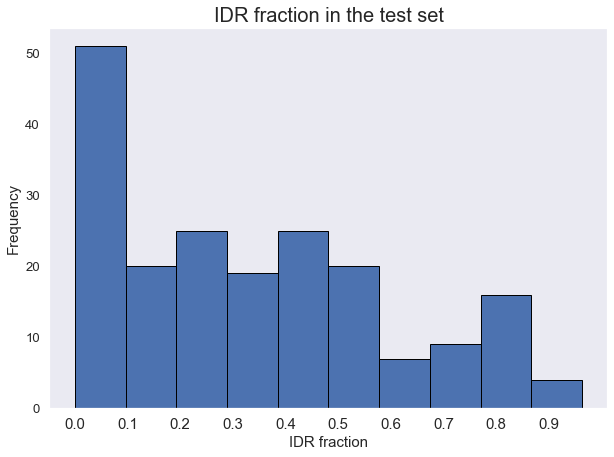

In [16]:
hist = proteins.hist(bins=10, column = 'IDR_fraction', xlabelsize = 15, figsize = (10,7), align = 'mid', ec='black', grid=False)

plt.xlabel('IDR fraction',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(np.arange(0, 1, 0.1))
plt.title('IDR fraction in the test set',fontsize=20)
plt.savefig('IDR_fraction.png', bbox_inches='tight', pad_inches = 0.0)

In [17]:
idr = temp_c_df.drop(['Sequence', 'Sequence_length', 'Hydrophobicity', 'Shannon_entropy'], axis = 1)
idr

,IDR_fraction
Uniprot_ID,
O00401,0.704950
O14641,0.464674
O15116,0.000000
O15169,0.548724
O15550,0.336188
...,...
Q9Y3R0,0.137411
Q9Y4Y9,0.000000
Q9Y4Z0,0.388489


In [18]:
idr['bins'] =pd.cut(idr['IDR_fraction'], np.arange(-0.001,1,0.1), precision=0)
idr

,IDR_fraction,bins
Uniprot_ID,,
O00401,0.704950,"(0.7, 0.8]"
O14641,0.464674,"(0.4, 0.5]"
O15116,0.000000,"(-0.001, 0.1]"
O15169,0.548724,"(0.5, 0.6]"
O15550,0.336188,"(0.3, 0.4]"
...,...,...
Q9Y3R0,0.137411,"(0.1, 0.2]"
Q9Y4Y9,0.000000,"(-0.001, 0.1]"
Q9Y4Z0,0.388489,"(0.3, 0.4]"


In [19]:
full_df = idr.join(men_with_venn, how = 'outer')

In [20]:
end_result=full_df.groupby(['bins']).mean()
end_result= end_result*100
end_result['protein counts'] = full_df['bins'].value_counts()
end_result= end_result.drop(['IDR_fraction'], axis=1)
end_result

,w2v_LLPS_PDB_RF,Phys_feat_LLPS_PDB_RF,w2v_LLPS_LLPS_RF,Phys_feat_LLPS_LLPS_RF,protein counts
bins,,,,,
"(-0.001, 0.1]",39.215686,27.450980,47.058824,23.529412,51
"(0.1, 0.2]",90.909091,95.454545,72.727273,72.727273,22
"(0.2, 0.3]",91.304348,95.652174,78.260870,82.608696,23
"(0.3, 0.4]",91.666667,100.000000,75.000000,75.000000,24
"(0.4, 0.5]",96.153846,100.000000,92.307692,96.153846,26
"(0.5, 0.6]",100.000000,100.000000,86.666667,93.333333,15
"(0.6, 0.7]",100.000000,100.000000,66.666667,88.888889,9
"(0.7, 0.8]",100.000000,100.000000,88.888889,100.000000,9
"(0.8, 0.9]",100.000000,100.000000,92.857143,85.714286,14


In [21]:
for_bar=end_result.drop(['protein counts'], axis=1)

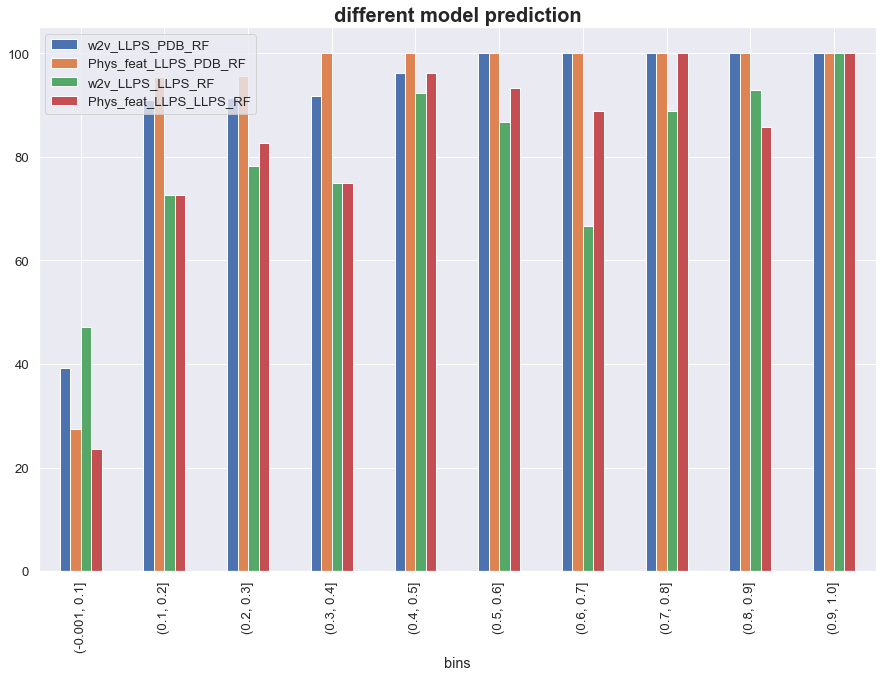

In [22]:
ax = for_bar.plot.bar(rot=90, figsize = (15,10))
plt.title('different model prediction', fontsize=20, fontweight = 'bold')
plt.savefig('big chart.png', bbox_inches='tight', pad_inches = 0.0)

In [23]:
gene_ontology = df3['Gene ontology (GO)'].tolist()


In [24]:
lst = [str(ontology).split(';') for ontology in gene_ontology]


In [25]:
flat_list = []
for sublist in lst:
    for item in sublist:
        flat_list.append(item)


In [26]:
flat_list = list(map(str.lstrip, flat_list))

In [27]:
flat_list1 =[]
for line in flat_list:
    line = line.split(' [')[0]
    flat_list1.append(line)


In [28]:
from collections import Counter

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
a = pd.Series(Counter(flat_list1))


In [31]:
b = a.to_frame()
b.columns = ['frequency']
b.index.name = 'gene ontology'
b['fraction of proteins'] = (b['frequency']/197)*100
b.nlargest(20,'frequency')
b.nlargest(20,'frequency').to_csv('196.csv')

In [32]:
b.to_csv('196 full.csv')

<ipython-input-34-c81b64a7ead3>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout() #may raise an exception, depends on which backend is in use


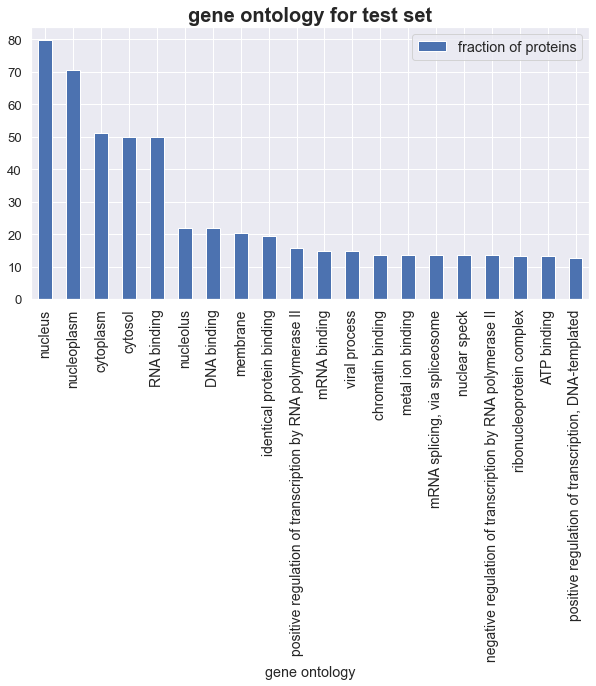

In [34]:
c=b.nlargest(20,'frequency')
ax = c.plot(kind ='bar', y='fraction of proteins', rot= 90, figsize = (10,5))
plt.title('gene ontology for test set', fontsize=20, fontweight = 'bold')
plt.legend(fontsize=30) 
plt.legend(fontsize="x-large")
plt.xticks(fontsize=14)


plt.tight_layout() #may raise an exception, depends on which backend is in use

plt.savefig('196.png', bbox_inches='tight', pad_inches = 0.0) #use bbox and pad, if you only want to change the saved figure. 



In [ ]:
proteins.corr()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(25,15))

x = proteins['IDR_fraction']

axs[0][0].scatter(x, proteins['w2v_LLPS_PDB_RF'], c = 'black', marker = 'x')
axs[0][0].set_title('w2v_LLPS_PDB_RF', fontweight="bold")
axs[0][1].scatter(x, proteins['Phys_feat_LLPS_PDB_RF'], c = 'black', marker = 'x')
axs[0][1].set_title('Phys_feat_LLPS_PDB_RF', fontweight="bold")
axs[1][0].scatter(x, proteins['w2v_LLPS_LLPS_RF'], c = 'black', marker = 'x')
axs[1][0].set_title('w2v_LLPS_LLPS_RF', fontweight="bold")
axs[1][1].scatter(x, proteins['Phys_feat_LLPS_LLPS_RF'], c = 'black', marker = 'x')
axs[1][1].set_title('Phys_feat_LLPS_LLPS_RF', fontweight="bold")

for ax in axs.flat:
    ax.set(xlabel='IDR fraction', ylabel='phase separation')
